###Imports

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import sentiment
#from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


###Data Analysis

In [2]:
TMR_PATH = '/content/IMDb_TLJ_Reviews.csv'

df = pd.read_csv(TMR_PATH, usecols = ['Reviews','Scores'])
df. rename(columns = {'Reviews':'review', 'Scores':'rating'}, inplace = True)
df.head()

,review,rating
0,I love the Star Wars franchise. I was so anxio...,3.0
1,After George Lucas's execrable prequels and th...,3.0
2,"Picking up where The Force Awakens left off, R...",4.0
3,"Modern Disney - you know, the one that has to ...",4.0
4,I didn't like Star Wars: The Last Jedi and I'm...,3.0


In [3]:
print("Shape", df.shape)

Shape (7050, 2)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  7050 non-null   object 
 1   rating  6801 non-null   float64
dtypes: float64(1), object(1)
memory usage: 110.3+ KB


In [5]:
df.isna().sum()
#there are 66 reviews which do not has associated ratings.

review      0
rating    249
dtype: int64

In [6]:
df = df[df['rating'].notna()]
print("Shape after filtering out NA ratings",df.shape)

Shape after filtering out NA ratings (6801, 2)


In [7]:
df['rating'] = df['rating'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6801 entries, 0 to 7049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  6801 non-null   object
 1   rating  6801 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 159.4+ KB


In [8]:
ratings = df.rating.unique()
print("Rating values : ",np.sort(ratings))
print("Len ( Rating ) : ",len(ratings))

Rating values :  [ 1  2  3  4  5  6  7  8  9 10]
Len ( Rating ) :  10


In [9]:
print(df["rating"].value_counts())

1     2446
2      800
10     554
3      546
8      493
9      467
7      411
4      394
6      355
5      335
Name: rating, dtype: int64


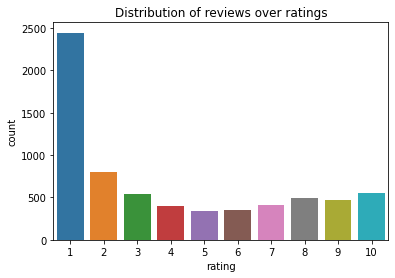

In [10]:
sns.countplot(df['rating'], data=df)
plt.title("Distribution of reviews over ratings")
plt.show()

* Every movie has a rating between 1-10.
* We have classified the ratings into 3 categories - Positive, Neutral, Negative.
* Positive = Rating [7,10]
* Neutral = Rating [5,6]
* Negative = Rating [1,4]
* We are focusing on Binary Classification of sentiments - Positive and Negative. Thus, we further filter out neutral rated reviews.


In [11]:
def generate_label(score):
    if score > 6 :
      return 'positive' #1
    elif score > 4 :
      return 'neutral' #0
    else : 
      return 'negative' #-1
    
#Assigning label to the dataset
df['label'] = df.apply(lambda x: generate_label(x['rating']), axis=1)
df.head(5)

,review,rating,label
0,I love the Star Wars franchise. I was so anxio...,3,negative
1,After George Lucas's execrable prequels and th...,3,negative
2,"Picking up where The Force Awakens left off, R...",4,negative
3,"Modern Disney - you know, the one that has to ...",4,negative
4,I didn't like Star Wars: The Last Jedi and I'm...,3,negative


In [12]:
print(df["label"].value_counts())

negative    4186
positive    1925
neutral      690
Name: label, dtype: int64


In [13]:
#filter out neutral sentiments
df= df[df['label']!= 'neutral']

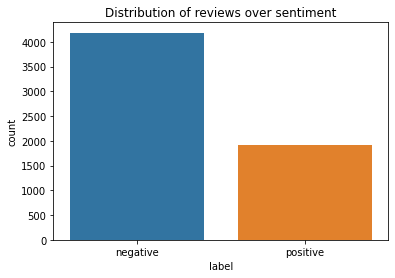

In [14]:
sns.countplot(df['label'], data=df)
plt.title("Distribution of reviews over sentiment")
plt.show()

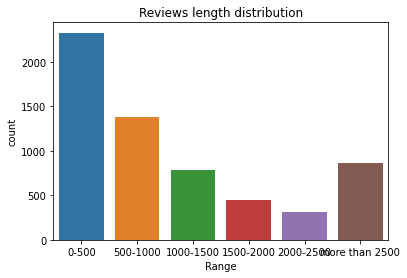

In [15]:
def calc_len(x):
  #print(len(x))
  return len(x)

df['wordcount'] = df['review'].apply(calc_len)
#df.head(5)

bins = [-1, 500, 1000, 1500, 2000, 2500, np.inf]
labels=['0-500','500-1000','1000-1500', '1500-2000', '2000-2500', 'more than 2500']
df['bins'] = pd.cut(df['wordcount'], bins=bins, labels=labels)

sns.countplot(df['bins'], data=df)
plt.title("Reviews length distribution")
plt.xlabel("Range")
plt.show()

In [16]:
df_wc=df.groupby(['bins','label']).size()
print (df_wc)

bins            label   
0-500           negative    1785
                positive     545
500-1000        negative     959
                positive     420
1000-1500       negative     487
                positive     293
1500-2000       negative     263
                positive     187
2000-2500       negative     194
                positive     119
more than 2500  negative     498
                positive     361
dtype: int64


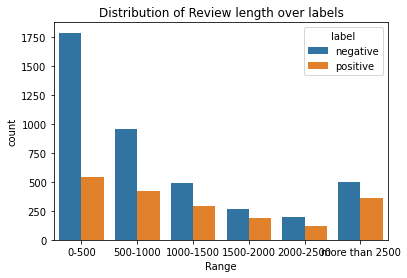

In [17]:
sns.countplot(x='bins', hue='label', data=df)
plt.title("Distribution of Review length over labels")
plt.xlabel("Range")
plt.show()

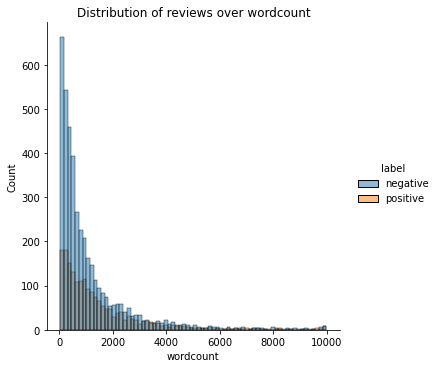

In [18]:
sns.displot(x= 'wordcount', hue = 'label', data = df)
plt.title('Distribution of reviews over wordcount')
plt.show()

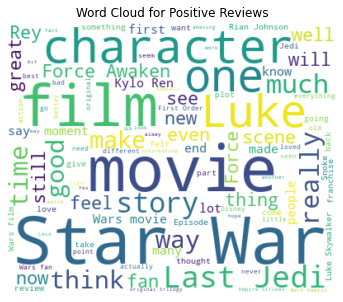

In [19]:
wcp = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df[df.label == 'positive'].review))

plt.figure(figsize=(15,5))
plt.imshow(wcp, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

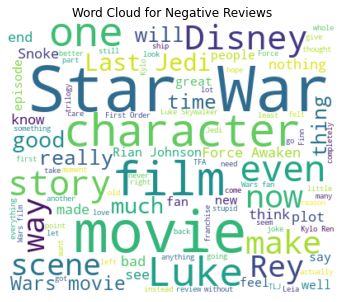

In [20]:
wcn = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df[df.label == 'negative'].review))

plt.figure(figsize=(15,5))
plt.imshow(wcn, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [21]:
pos_wf = list(wcp.words_.keys())
neg_wf = list(wcn.words_.keys())
print("Positive Reviews : ",pos_wf)
print("Negative Reviews : ",neg_wf)
common = [x for x in pos_wf if x in neg_wf]
print("Common : ", common)

Positive Reviews :  ['Star War', 'movie', 'film', 'character', 'one', 'Luke', 'Last Jedi', 'story', 'much', 'time', 'really', 'good', 'think', 'way', 'make', 'Force Awaken', 'scene', 'will', 'new', 'thing', 'see', 'even', 'Rey', 'great', 'feel', 'still', 'Force', 'now', 'well', 'fan', 'Kylo Ren', 'Wars movie', 'people', 'lot', 'many', 'end', 'made', 'moment', 'say', 'know', 'first', 'Rian Johnson', 'going', 'part', 'take', 'Snoke', 'franchise', 'Jedi', 'plot', 'something', 'Luke Skywalker', 'love', 'want', 'come', 'give', 'thought', 'Episode', 'review', 'back', 'felt', 'Wars film', 'everything', 'action', 'little', 'different', 'actually', 'better', 'point', 'go', 'original', 'loved', 'Wars fan', 'seem', 'First Order', 'Disney', 'seen', 'best', 'never', 'us', 'old', 'need', 'bad', 'original trilogy', 'look', 'alway', 'amazing', 'interesting', 'overall', 'another', 'Leia', 'bit', 'Mark Hamill', 'hope', 'Empire Strikes', 'right', 'may', 'Yes', 'fact', 'work', 'watch']
Negative Reviews : 

* Words like [Star war, movie, film, character, one, Luke, Jedi, Last, story, time, really, make ] are frequent in both the sentiments, thus they do not help in classification. 
* We will ignore these words during data cleaning.

### Data Cleaning

In [35]:
IGNORE_WORDS = ['Star' ,'war', 'movie', 'film', 'character', 'one', 'Luke', 'Jedi', 'Last', 'story', 'time', 'really', 'make' ]

def clean_data(review):
    #print("Org : " , review)

    #HTML tag
    raw_text=BeautifulSoup(review, 'html').get_text()
    #print("Html : ",raw_text)

    #urls
    raw_text = re.sub(r"(www|http:|https:)+[\S]+[\w]", "", raw_text)
    #print("Links : ",raw_text)
    
    #non English character
    letters = re.sub('[^a-zA-Z]', ' ', raw_text)
    #print("Non English : ",letters)

    #lowercase
    tokens = letters.lower().split() 

    #filter ignore_words
    #tokens = [token for token in tokens if token not in IGNORE_WORDS] 
    #print(tokens)

    #stopwords and stemming
    stopwords = nltk.corpus.stopwords.words('english')
    wn = nltk.WordNetLemmatizer()
    words = [wn.lemmatize(w) for w in tokens if w not in stopwords ]
    
    #ignore_words
    IGNORE_WORDS_LEM = [wn.lemmatize(w).lower() for w in IGNORE_WORDS]
    words = [w for w in words if w not in IGNORE_WORDS_LEM]

    #ps = nltk.PorterStemmer()
    #words = [ps.stem(w) for w in tokens if w not in stopwords]
    
    #print("Tokens : ",words)
    return words

In [47]:
clean_data("film! this is test aaa <br> https://urls.com, is good with <b>technology</b>! Tests failed? Jedi movies one two")

['test', 'aaa', 'good', 'technology', 'test', 'failed', 'two']

In [37]:
df_X =  df['review'].apply(clean_data)
df_Y = df['label']
print(df_X.shape, df_Y.shape)

(6111,) (6111,)


In [38]:
def generate_vocab(data): 
  vocab = set()
  for clean_x in data : #cleaned_data
    for word in clean_x :
      #print(word)
      vocab.add(word)
      #break
  return sorted(vocab)

vocab = generate_vocab(df_X)
print("Vocab : ",vocab)
print("Length : ", len(vocab))

Vocab :  ['aa', 'aaa', 'aaaaand', 'aaaaggghh', 'aaaannnddd', 'aaaanyway', 'aaah', 'aaahs', 'aardvark', 'aaron', 'aback', 'abad', 'abaloth', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abborent', 'abc', 'abdicating', 'abdication', 'abdomen', 'abduct', 'abducted', 'abe', 'aberrant', 'aberration', 'abhor', 'abhorred', 'abhorrent', 'abhrams', 'abide', 'abides', 'abiding', 'ability', 'abilty', 'abit', 'abject', 'ablaze', 'able', 'ably', 'aboard', 'abolish', 'abominable', 'abomination', 'abondoned', 'aborted', 'abortion', 'abotu', 'abou', 'aboujt', 'abound', 'abounded', 'abounds', 'aboutall', 'abraham', 'abrahamic', 'abrahms', 'abram', 'abramms', 'abrams', 'abrans', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absense', 'absent', 'absentee', 'absentplot', 'absents', 'absolut', 'absolute', 'absolutelly', 'absolutely', 'absolutism', 'absolutley', 'absolutly', 'absorb', 'absorbed', 'absorbing', 'abstain', 'abstemious', 'abstinence', 'abstract', 'absurd', 'absurdity', 'absurdly', 'a

###Feature Extraction

####BagOfWords

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(analyzer = "word", tokenizer = lambda x: x, lowercase=False,  preprocessor = None, stop_words = None)
train_features = bow_vectorizer.fit_transform(df_X).toarray()
dfbow = pd.DataFrame(data=train_features,columns = bow_vectorizer.get_feature_names())
print(dfbow.shape)
dfbow.head()

(6111, 23778)


,aa,aaa,aaaaand,aaaaggghh,aaaannnddd,aaaanyway,aaah,aaahs,aardvark,aaron,...,zoned,zoo,zoom,zoomed,zooming,zornord,zu,zucchini,zv,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
features_count =  np.sum(train_features,axis=0)
features_count = pd.DataFrame(dict(features = bow_vectorizer.get_feature_names(), counts = features_count))
features_count.sort_values('counts', ascending=False)[0:20]

,features,counts
12074,like,6404
8215,force,4990
13858,new,3997
17576,rey,3736
8934,good,3602
7149,even,3425
7605,fan,3290
23529,would,3130
7975,first,3053
18154,scene,3047


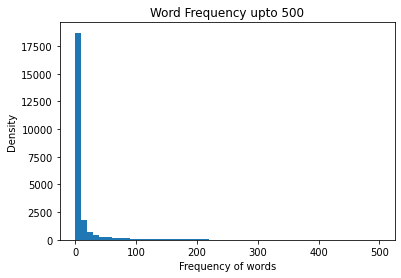

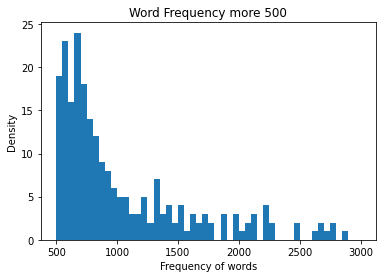

In [49]:
plt.title("Word Frequency upto 500")
plt.hist(features_count.counts, bins=50, range=(0,500))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

plt.title("Word Frequency more 500")
plt.hist(features_count.counts, bins=50, range=(500,3000))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

In [42]:
print("Features in bag of words : ",len(bow_vectorizer.vocabulary_))

Features in bag of words :  23778


####  TF-IDF

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, use_idf=True) #stop_words='english' , smooth_idf=True(default)
tfidf = tfidf_vectorizer.fit_transform(df_X)

#print("Vocab : \n ",tfidf_vectorizer.vocabulary_) #mapping{word: feature index}
print("IDF Vector : \n ",tfidf_vectorizer.idf_)

IDF Vector : 
  [9.02486215 8.61939704 8.61939704 ... 9.02486215 9.02486215 9.02486215]


In [44]:
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head(20)

,idf_weights
like,1.781349
force,2.012747
good,2.047581
new,2.090465
even,2.151698
fan,2.163675
plot,2.196150
see,2.208126
would,2.267349
much,2.283161


These are only IDF values. Inverse Document Frequency Score is inversely proportional to the usage frequency of the words. Not so important words which may not tell the context has lower IDF since they appear in every sentences.

In [45]:
idx = 5
print("\n Review tokens : ",df_X.loc[idx])
df_tfidf = pd.DataFrame(tfidf[idx].T.todense(), index=tfidf_vectorizer.get_feature_names_out (), columns=["tfidf"])
df_tfidf.sort_values(by=["tfidf"],ascending=False).head(20)


 Review tokens :  ['sort', 'review', 'helpfulness', 'find', 'single', 'review', 'score', 'higher', 'come', 'overall', 'score', 'something', 'adding']


,tfidf
helpfulness,0.476704
score,0.467658
higher,0.327790
adding,0.317182
review,0.314267
sort,0.256416
single,0.229486
overall,0.199880
find,0.192353
come,0.163126


Here, we see TFIDF values for 5th document of our trainset. We can explore other values by updating the value of idx.

In [46]:
print("Number of features : ",len(tfidf_vectorizer.vocabulary_))

Number of features :  23778
